In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
az.style.use('arviz-white')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});

<center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Análisis exploratorio de modelos Bayesianos</h1> 
<h2 align="center">Comparación de modelos</h2>



<br>
<br>
<br>
<br>
<br>

## ArviZ: Análisis exploratorio de modelos Bayesianos

<br>
<br>
<center><img src="img/logo_arviz.png" width=500></center>
<br>

* <font color = "gray"> Diagnosticar la calidad de la inferencia </font>
* <font color = "gray"> Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones </font>
* Comparación de modelos, incluyendo la selección y promediado de modelos
* <font color = "gray"> Preparar los resultados para una audiencia particular </font>

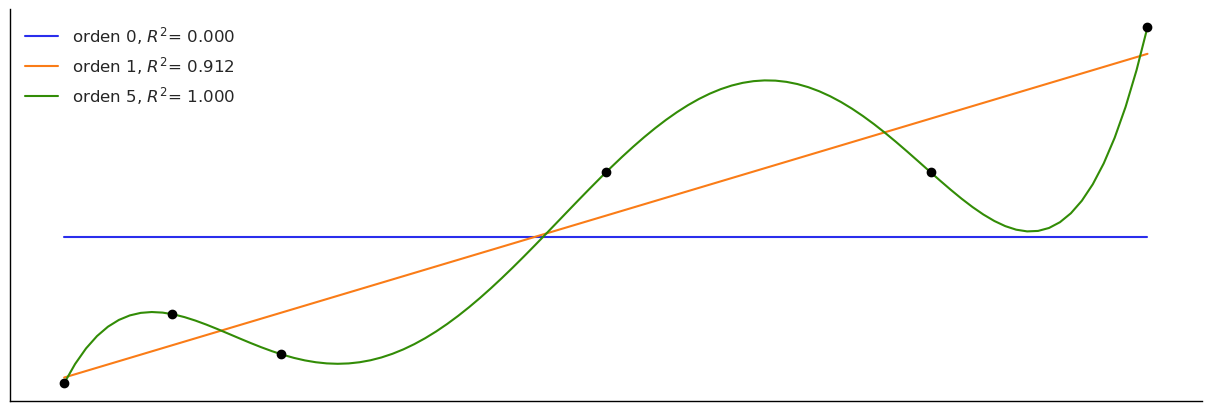

In [15]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4., 5., 6., 9., 12, 14.])
y0 = np.array([4.2, 6.1, 5., 10., 10, 14.])

order = [0, 1, 5]
ax.plot(x0, y0, 'ko', zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat-y0)**2)
    ss_total = np.sum((ybar-y0)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

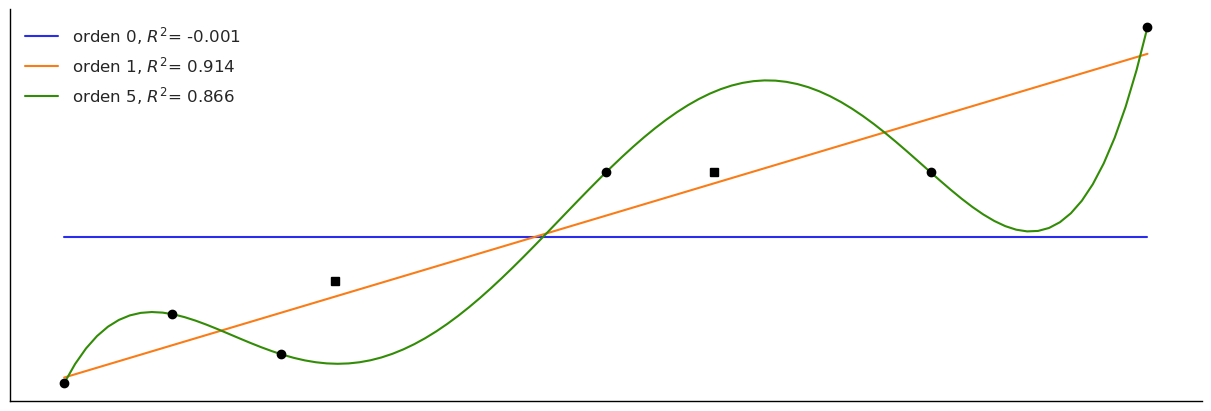

In [16]:
_, ax = plt.subplots( figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, 'ko', zorder=3)
ax.plot(x_, y_, 'ks', zorder=3)

ax.set_yticks([])
ax.set_xticks([])

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

for idx, i in enumerate(order):
    yhat = ps[idx](x1)
    ybar = np.mean(y1)
    ss_regression = np.sum((yhat-y1)**2)
    ss_total = np.sum((ybar-y1)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, ps[idx](x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

## Medidas de precisión predictiva


<br>

* **precisión dentro de la muestra**: la exactitud medida con los datos utilizados para ajustar un modelo


* **precisión fuera de la muestra** (o exactitud predictiva): la exactitud del modelo medido con datos no utilizados para ajustar el modelo



* Si solo usamos la exactitud dentro de la muestra podríamos pensar que tenemos un modelo mejor de lo que realmente es


## Medidas de precisión predictiva

<br>

* Utilizar la precisión fuera de la muestra, requiere dejar de lado una porción de los datos durante el ajuste, y usar esa porción solo para la evaluación. Esto suele ser un lujo.


* Alternativas:
     * Validación cruzada
     * Criterios de información

## Criterios de información


* Los criterios de información estiman la precisión fuera de la muestra a partir de la precisión dentro de la muestra

* El AIC es un criterio de información muy conocido y ampliamente utilizado, especialmente fuera del mundo Bayesiano. Se define como:

$$AIC = -2 \underbrace{\sum_{i}^{N} \log p(y_i \mid \hat{\theta}_{mle})}_{\text{bondad ajuste}} + \overbrace{\; 2 k \;
}^{\text{penalización}} $$

Donde
* $\hat {\theta}_{mle}$ es una estimación puntual, la suma se realiza sobre las $N$ observaciones

* $k$ es la cantidad de parámetros del modelo.

## Validación cruzada (crossvalidation, CV)

<br>


* Existen muchas [variantes](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), pero de forma general...


* Dado un conjunto de datos lo dividimos en 2 grupos

* Un grupo lo usamos para entrenar/ajustar el modelo (train)

* El otro para evaluar el ajuste (test)


## k-fold-CV

<br>

* Dividimos los datos en k-grupos (sin repetir datos) los usamos para ajustar el modelo k-veces

<br>


<center><img src="img/KfoldCV.gif" width=600></center>


## LOO-CV

<br>

* Si k=1 entonces tenemos leave-one-out-CV. Hay que ajustar el modelo tantas veces como datos tengamos

<br>


<center><img src="img/LOOCV.gif" width=500></center>


## Leave-One-Out-Cross-Validation

<br>


$$
\text{ELPD}_\text{LOO-CV} = \sum_{i=1}^{n} \log
    \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y_{-i}) d\boldsymbol{\theta}
$$

$$
\sum_{i}^{n} \log
    \left(\frac{1}{s}\sum_j^s \ \color{#E9692C}{p(y_i \mid \boldsymbol{\theta_{-i}^j})} \right)
$$


* Es posible aproximar $\color{#E9692C}{p(y_i \mid \boldsymbol{\theta_{-i}^j})}$ usando un método llamado Pareto-Smooth-Importance-Sampling

## Leche de primates

* Queremos explorar la composición de la leche en varias especies de primates.

* Se presume que las hembras de especies de primates con cerebros más grandes producen leche más nutritiva

* Usaremos 3 variables
     * La proporción de neocorteza respecto de la masa total del cerebro
     * El logaritmo de la masa corporal de las madres
     * Las kilocalorías por gramo de leche (variable respuesta)
    
* Usaremos 3 modelos lineales diferentes:
     1. Un modelo que usa solo la variable neocorteza
     2. Un modelo que usa solo el logaritmo de la variable de masa
     3. Un modelo que usa ambas variables

[Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)

In [7]:
d = pd.read_csv('../datos/milk.csv')
d.iloc[:,1:] = d.iloc[:,1:] - d.iloc[:,1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-0.123706,-0.831353
1,0.47,-0.030706,0.158647
2,0.56,-0.030706,0.181647
3,0.89,0.000294,-0.579353
4,0.92,0.012294,-1.885353


In [8]:
with pm.Model() as modelo_0:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfNormal('σ', 10)
    
    μ = α + β * d['neocortex']
    
    kcal = pm.Normal('kcal', mu=μ, sigma=σ, observed=d['kcal.per.g'])
    idata_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [9]:
with pm.Model() as model0_1:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', 10)
    
    μ = α + β * d['log_mass']
    
    kcal = pm.Normal('kcal', mu=μ, sigma=σ, observed=d['kcal.per.g'])
    
    idata_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [10]:
with pm.Model() as model1_2:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1, shape=2)
    σ = pm.HalfNormal('σ', 10)

    μ = α + pm.math.dot(β, d[['neocortex','log_mass']].T)

    kcal = pm.Normal('kcal', mu=μ, sigma=σ, observed=d['kcal.per.g'])

    idata_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


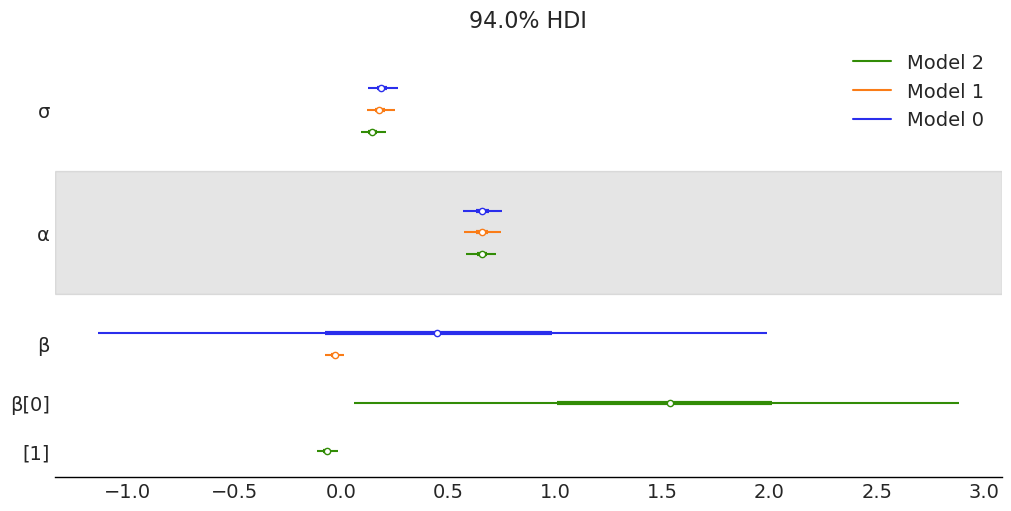

In [11]:
idatas = [idata_0, idata_1, idata_2]
az.plot_forest(idatas, figsize=(10, 5), combined=True);

In [12]:
model_dict = dict(zip(['model_0', 'model_1', 'model_2'], idatas))
comp = az.compare(model_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2,0,7.517071,2.782225,0.000000,1.000000e+00,2.540048,0.000000,False,log
model_1,1,4.449432,2.032504,3.067639,0.000000e+00,2.048576,1.104597,False,log
model_0,2,3.546080,1.959335,3.970992,2.220446e-16,1.555893,2.131862,False,log


## Interpretando la comparación

* elpd_loo: contiene los valores de LOO
* p_loo: el *número efectivo de parámetros* (no lo tomen demasiado en serio)
* elpd_diff: la diferencia relativa entre el valor de LOO para el modelo mejor clasificado y el valor de LOO para cada modelo
* weight: peso relativo (o probabilidad) de cada modelo (dentro de los modelos comparados)
* se: el error estándar de LOO
* dse: el error estándar de las diferencias entre el valor de LOO para el modelo mejor clasificado y el valor de LOO para cada modelo.
* warning: indica que el cálculo de LOO puede no ser confiable
* scale: indica la escala usada para reportar los valores de LOO. La escala usada por defecto es 
`log`, valores más grandes de loo indican mejores modelos.

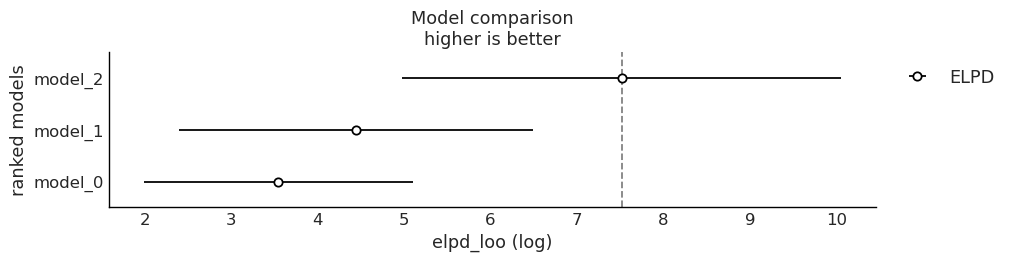

In [13]:
az.plot_compare(comp, insample_dev=False, plot_ic_diff=False, figsize=(10, 2.5));

In [14]:
loo_i_2 = az.loo(trace_2, pointwise=True).loo_i
loo_i_1 = az.loo(trace_1, pointwise=True).loo_i

NameError: name 'trace_2' is not defined

In [ ]:
plt.plot(d.index, loo_i_2 - loo_i_1, 'C0.')
plt.axhline(0, color='k', ls='--')
plt.ylabel('Δ LOO')
plt.xlabel('Index');

## Promediando modelos


* En lugar de elegir el mejor modelo, podemos obtener un *metamodelo* promediando todos los modelos

$$w_i = \frac {e^{ - \frac{1}{2} dIC_i }} {\sum_j^M e^{ - \frac{1}{2} dIC_j }}$$


* Podemos usar los pesos obtenidos de `az.compare`
* Podemos usar `pm.sample_posterior_predictive_w` para obtener predicciones de los modelos ponderados

In [ ]:
# weighted predictions
ppc_w = pm.sample_posterior_predictive_w(traces, 2000, [model_0, model_1, model_2],
                        weights=comp.weight.sort_index(ascending=True), progressbar=False)

# predictions from model 2
ppc_2 = pm.sample_posterior_predictive(trace_2, 2000, model_2, progressbar=False)

In [ ]:
mean_w = ppc_w['kcal'].mean()
hpd_w = pm.hpd(ppc_w['kcal']).mean(0)

mean = ppc_2['kcal'].mean()
hpd = pm.hpd(ppc_2['kcal']).mean(0)

#plt.figure(figsize=(6,3))
plt.errorbar(mean, 0.2, xerr=[[mean-hpd[0]], [hpd[1]-mean]], fmt='o', label='modelo 2')
plt.errorbar(mean_w, 0, xerr=[[mean_w-hpd_w[0]], [hpd_w[1]-mean_w]], fmt='o', label='modelos pesados')

plt.yticks([])
plt.ylim(-0.5, 1)
plt.xlabel('kcal per g')
plt.legend();

# Factores de Bayes

Reescribamos el teorema de Bayes, haciendo explícita la dependencia de la inferencia en un modelo dado $ M $:

$$p(\theta \mid y, M_k) = {\frac {p(y \mid \theta, M_k)p(\theta \mid M_k)}{p(y \mid M_k)}}$$

El término en el denominador se conoce como marginal likelihood, el cociente entre dos likelihood marginales se conoce como factor de Bayes:

$$BF = \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

* cuando BF > 1, el modelo 0 explica los datos mejor que el modelo 1

* Usar $p(y \mid M_k)$ para comparar modelos está bien si todo los **modelos** tienen la misma probabilidad a priori.

* Caso contrario tenemos que calcular los _posterior odds_:

$$\underbrace{\frac{p(M_0 \mid y)}{p(M_1 \mid y)}}_\text{posterior odds} = \underbrace{\frac{p(y \mid M_0)}{p(y \mid M_1)}}_\text{Bayes factors} \, \underbrace{\frac{p(\ M_0 \ )}{p(\ M_1 \ )}}_\text{prior odds}$$

## Algunos comentarios sobre los factores de Bayes


$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) p(\theta_k, M_k) d\theta_k$$


* Lo bueno: los modelos con más parámetros tienen una penalización mayor que los modelos con menos parámetros. La razón intuitiva es que cuanto mayor sea el número de parámetros, mayor será la dispersión del prior respecto del likelihood

* Lo malo: calcular la probabilidad marginal es, en general, una tarea difícil porque es una integral de una función altamente variable en un espacio de parámetros de alta dimensión.

* Lo feo: la probabilidad marginal depende *sensiblemente* de los valores del prior

* Una forma relativamente simple de calcular los factores de Bayes con PyMC3 es mediante el uso del método de inferencia SMC

In [ ]:
np.exp(idata_BF_0.sample_stats.log_marginal_likelihood.mean() - idata_BF_1.sample_stats.log_marginal_likelihood.mean())

In [ ]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y = pm.Bernoulli('y', theta, observed=y_d)
    idata_BF_0 = pm.sample_smc(2500)

with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y = pm.Bernoulli('y', theta, observed=y_d)
    idata_BF_1 = pm.sample_smc(2500)

In [ ]:
np.exp(idata_BF_0.sample_stats.log_marginal_likelihood.mean().item() - 
       idata_BF_1.sample_stats.log_marginal_likelihood.mean().item())

## Criterios de información vs Factores de Bayes

* El factor Bayes se centra en averiguar cual modelo es mejor (y el posterior es parte del modelo)

* WAIC (y LOO) se centran en cual modelo dará las mejores predicciones (el prior se tienen en cuenta indirectamente)

## Ejercicios

1. Explique porqué WAIC es más general que AIC. ¿Bajo que condiciones estos dos criterios son numéricamente similares?

1. ¿Cuál es la diferencia entre seleccionar modelos y promediar modelos?

1. Al comparar modelos usando criterios de información es necesario usar el mismo conjunto de datos. ¿Por qué? ¿Qué sucede si cambiamos la cantidad de datos?

1. ¿Cómo cambia el número efectivo de parámetros (medio por WAIC) a medida que el prior se concentra más?

1. ¿Cómo se vincula la respuesta anterior con el concepto de regularización y con el concepto de modelos jerárquicos? ¿Puede un prior reducir el overfitting? ¿Puede un prior favorecer el underfitting?

1. Calcule WAIC y BF para los modelos model_BF_0 y model_BF_1. Use (monedas = 30, caras = 9) y luego (monedas = 300, caras = 90). Compare las diferencias en términos de WAIC y BF al aumentar los datos.